In [1]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from utils import utils
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
from scipy.spatial import cKDTree
import numpy as np

PERIM_X = [-70.42034224747098, -70.36743722434367]
PERIM_Y = [-23.721724880116387, -23.511242421131792]

PERIM_AFTA = gpd.GeoDataFrame(geometry=gpd.points_from_xy(PERIM_X, PERIM_Y))
PERIM_AFTA.crs = "EPSG:4326"
PERIM_AFTA = PERIM_AFTA.to_crs("EPSG:3857")

alerts = utils.get_data()

alerts.data.head(3)

,country,city,reportRating,reportByMunicipalityUser,confidence,reliability,type,uuid,roadType,magvar,subtype,street,pubMillis,endreport,reportDescription,x,y,geometry
0,CI,Antofagasta,1,false,5,10,HAZARD,a123f22e-e5e0-4c6c-8a4e-7434c4fd2110,6.0,17,HAZARD_ON_ROAD_CONSTRUCTION,Av. República de Croacia,1724417637000,1.724425e+12,NaN,-70.412429,-23.676846,POINT (-7838275.742 -2714079.538)
1,CI,Antofagasta,0,false,0,5,JAM,1d8df954-e380-4327-8015-f4fbadf74f2d,6.0,4,JAM_HEAVY_TRAFFIC,Av. Edmundo Pérez Zujovic,1724423878000,1.724425e+12,NaN,-70.392283,-23.617475,POINT (-7836033.099 -2706864.568)
2,CI,Antofagasta,0,false,0,5,JAM,c53a5bc6-f6b6-44b8-a5bd-af69b60a4580,1.0,359,,Pasaje El Volcán,1724425406000,1.724425e+12,NaN,-70.385619,-23.573323,POINT (-7835291.266 -2701501.184)


In [ ]:
#
def filter_nearby(gdf, threshold=500):
    """
    Filtra los puntos que tienen otros puntos cercanos dentro de un umbral dado.
    Retorna un GeoDataFrame con puntos únicos sin vecinos cercanos.

    Parámetros:
    - gdf: GeoDataFrame con geometrías de puntos.
    - threshold: Distancia umbral en metros.

    Retorna:
    - GeoDataFrame filtrado.
    """
    # Verificar y reproyectar si es necesario
    if gdf.crs.is_geographic:
        gdf = gdf.to_crs(epsg=3857)

    # Extraer coordenadas x e y
    coords = np.vstack((gdf.geometry.x, gdf.geometry.y)).T

    # Construir el cKDTree
    tree = cKDTree(coords)

    # Inicializar un arreglo booleano para marcar los puntos a conservar
    n_points = len(gdf)
    keep = np.ones(n_points, dtype=bool)

    # Iterar sobre cada punto
    for idx in range(n_points):
        if keep[idx]:
            # Encontrar los índices de los puntos dentro del umbral
            indices = tree.query_ball_point(coords[idx], r=threshold)
            # Excluir el propio punto
            indices = [i for i in indices if i != idx]
            # Marcar los vecinos cercanos como False (eliminados)
            keep[indices] = False
        else:
            continue

    # Filtrar el GeoDataFrame
    return gdf[keep].reset_index(drop=True)

In [2]:
accidents = alerts.data[alerts.data["type"] == "ACCIDENT"]
jams = alerts.data[alerts.data["type"] == "JAM"]
hazards = alerts.data[alerts.data["type"] == "HAZARD"]

In [3]:
print("Las 10 calles con más accidentes son:")
print(accidents["street"].value_counts().head(10))

Las 10 calles con más accidentes son:
street
Av. Edmundo Pérez Zujovic               164
Av. Pedro Aguirre Cerda                 134
Nicolás Tirado                           50
Av. Antonio Rendic                       47
Av. Grecia                               47
Av. Iquique                              26
Av. Balmaceda                            22
Circunvalación Padre Alberto Hurtado     20
Av. Argentina                            20
Av. Óscar Bonilla                        19
Name: count, dtype: int64


In [4]:
print("Las 10 calles con más atascos son:")
print(jams["street"].value_counts().head(10))

Las 10 calles con más atascos son:
street
Av. Edmundo Pérez Zujovic    1817
Av. Pedro Aguirre Cerda       555
Av. Grecia                    520
Av. Iquique                   359
Av. Antonio Rendic            348
Av. Balmaceda                 236
Av. Argentina                 141
Nicolás Tirado                141
Av. Séptimo de Línea          125
Av. Óscar Bonilla             120
Name: count, dtype: int64


In [5]:
print("Las 10 calles con más peligros son:")
print(hazards["street"].value_counts().head(10))

Las 10 calles con más peligros son:
street
Av. Edmundo Pérez Zujovic               448
Av. Argentina                           222
Av. Antonio Rendic                      199
Av. Grecia                              194
Av. Pedro Aguirre Cerda                 192
Av. Balmaceda                           106
Circunvalación Padre Alberto Hurtado     87
Av. Andrés Sabella                       85
Av. Salvador Allende                     78
Av. Séptimo de Línea                     66
Name: count, dtype: int64


In [6]:
utils.freq_nearby(accidents)

,uuid,street,inicio,fin,x,y,geometry,hour,week_day,day_type,freq
4,e87552f7-4572-4096-9fdd-9400ad90e7f8,Irarrázaval,2024-08-23 11:12:19-04:00,2024-08-23 14:58:45-04:00,-70.385121,-23.603942,POINT (-7835235.829 -2705220.449),11,4,s,5
88,dcc53b30-3046-4d56-bc84-29284233f1f0,Díaz Gana,2024-08-23 14:34:02-04:00,2024-08-23 14:58:45-04:00,-70.403283,-23.665486,POINT (-7837257.614 -2712698.778),14,4,s,9
89,2340df84-4283-49c7-91ed-dff4a345b272,Av. Angamos,2024-08-23 14:33:40-04:00,2024-08-23 14:58:45-04:00,-70.403216,-23.665352,POINT (-7837250.155 -2712682.492),14,4,s,9
96,4a3425e5-838a-4a94-acc6-1c2880648355,Av. Edmundo Pérez Zujovic,2024-08-23 14:43:35-04:00,2024-08-23 14:58:45-04:00,-70.396410,-23.628191,POINT (-7836492.515 -2708166.572),14,4,s,10
101,c83aab00-41d5-4795-8314-1bc05e851a4a,Av. Grecia,2024-08-23 15:29:55-04:00,2024-08-23 14:58:45-04:00,-70.402631,-23.654842,POINT (-7837185.033 -2711405.154),15,4,s,6
...,...,...,...,...,...,...,...,...,...,...,...
11114,cc9108d3-be9a-441c-a0e7-a206374ab8aa,Antonio José de Sucre,2024-10-12 17:17:07-03:00,2024-10-10 23:34:44-03:00,-70.398307,-23.645190,POINT (-7836703.688 -2710232.184),17,5,f,5
11131,0e6aa831-f534-4e8e-82f0-59ff2fe845cc,Av. Antonio Rendic,2024-10-12 17:55:14-03:00,2024-10-10 23:34:44-03:00,-70.388855,-23.638849,POINT (-7835651.496 -2709461.634),17,5,f,3
11162,8f038029-893c-44ef-9fb0-efa97c9c7f09,Acceso Playa Paraíso,2024-10-12 18:49:11-03:00,2024-10-10 23:34:44-03:00,-70.396765,-23.638764,POINT (-7836532.033 -2709451.305),18,5,f,6
11176,d58f0f20-c7bb-499c-838b-91820d707978,Av. Angamos,2024-10-12 19:12:38-03:00,2024-10-10 23:34:44-03:00,-70.410713,-23.679989,POINT (-7838084.718 -2714461.578),19,5,f,0


In [7]:
accidents = filter_nearby(accidents, threshold=500)
top10 = accidents[["street", "freq", "x", "y", "geometry"]].sort_values("freq", ascending=False).head(10)

accidents10 = top10.copy()
top10

,street,freq,x,y,geometry
32,Nicolás Tirado,62,-70.388786,-23.591896,POINT (-7835643.815 -2703757.127)
71,Av. Edmundo Pérez Zujovic,25,-70.393390,-23.584144,POINT (-7836156.33 -2702815.503)
50,Av. Pedro Aguirre Cerda,19,-70.390059,-23.586442,POINT (-7835785.525 -2703094.632)
36,Av. Grecia,18,-70.402744,-23.648818,POINT (-7837197.613 -2710673.071)
66,Jorge Washington,16,-70.400162,-23.647439,POINT (-7836910.186 -2710505.488)
5,Av. Edmundo Pérez Zujovic,16,-70.396341,-23.591243,POINT (-7836484.834 -2703677.806)
95,Av. Iquique,13,-70.394007,-23.629351,POINT (-7836225.014 -2708307.519)
69,Av. Pedro Aguirre Cerda,12,-70.390902,-23.571555,POINT (-7835879.367 -2701286.452)
85,Av. Edmundo Pérez Zujovic,11,-70.397002,-23.570898,POINT (-7836558.416 -2701206.658)
82,Av. Edmundo Pérez Zujovic,11,-70.395769,-23.637457,POINT (-7836421.159 -2709292.485)


In [8]:
print("Las 10 coordenadas con más accidentes son:")
for _, row in top10.iterrows():
    print(f"{row['y']}, {row['x']}")

Las 10 coordenadas con más accidentes son:
-23.591896, -70.388786
-23.584144, -70.39339
-23.586442, -70.390059
-23.648818, -70.402744
-23.647439, -70.400162
-23.591243, -70.396341
-23.629351, -70.394007
-23.571555, -70.390902
-23.570898, -70.397002
-23.637457, -70.395769


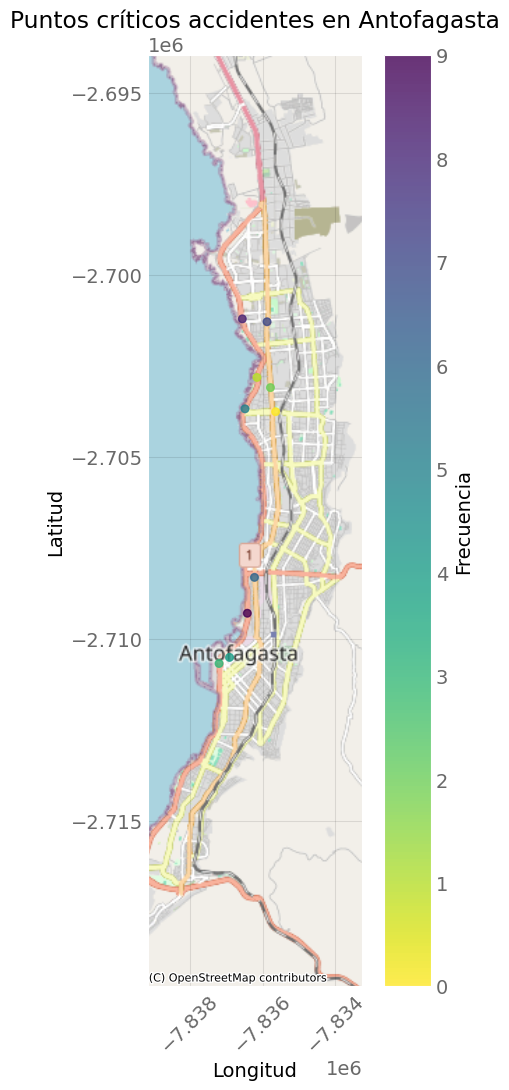

,street,freq,x,y,geometry
32,Nicolás Tirado,62,-70.388786,-23.591896,POINT (-7835643.815 -2703757.127)
71,Av. Edmundo Pérez Zujovic,25,-70.393390,-23.584144,POINT (-7836156.33 -2702815.503)
50,Av. Pedro Aguirre Cerda,19,-70.390059,-23.586442,POINT (-7835785.525 -2703094.632)
36,Av. Grecia,18,-70.402744,-23.648818,POINT (-7837197.613 -2710673.071)
66,Jorge Washington,16,-70.400162,-23.647439,POINT (-7836910.186 -2710505.488)
5,Av. Edmundo Pérez Zujovic,16,-70.396341,-23.591243,POINT (-7836484.834 -2703677.806)
95,Av. Iquique,13,-70.394007,-23.629351,POINT (-7836225.014 -2708307.519)
69,Av. Pedro Aguirre Cerda,12,-70.390902,-23.571555,POINT (-7835879.367 -2701286.452)
85,Av. Edmundo Pérez Zujovic,11,-70.397002,-23.570898,POINT (-7836558.416 -2701206.658)
82,Av. Edmundo Pérez Zujovic,11,-70.395769,-23.637457,POINT (-7836421.159 -2709292.485)


In [9]:

def plot_map(
    data: gpd.GeoDataFrame,
    title: str,
    cmap: str = "viridis",
    markersize: int = 10,
    ax: Axes | None = None,
    figsize: tuple = (4.5, 9.5),
) -> tuple[Figure | None, Axes]:
    """Grafica un GeoDataFrame en un eje de coordenadas"""

    fig = None

    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(figsize)

    sc = data.to_crs(epsg=3857).geometry.plot(ax=ax, cmap=cmap, alpha=0.8, markersize=markersize, c=data.freq)
    ax.set_xlim(PERIM_AFTA.total_bounds[0], PERIM_AFTA.total_bounds[2])
    ax.set_ylim(PERIM_AFTA.total_bounds[1], PERIM_AFTA.total_bounds[3])
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
    cbar = sc.get_figure().colorbar(sc.collections[0], ax=ax)
    cbar.set_label("Frecuencia")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    plt.xticks(rotation=45)
    ax.set_title(title)
    plt.tight_layout()
    if fig:
        return fig, ax
    return None, ax

In [ ]:
MARKERSIZE = 50

fig, ax = plot_map(accidents10, "Puntos críticos accidentes en Antofagasta", markersize=MARKERSIZE, cmap="viridis_r")
plt.show()
accidents10

In [10]:
utils.freq_nearby(jams)

,uuid,street,inicio,fin,x,y,geometry,hour,week_day,day_type,freq
1,1d8df954-e380-4327-8015-f4fbadf74f2d,Av. Edmundo Pérez Zujovic,2024-08-23 10:37:58-04:00,2024-08-23 14:58:45-04:00,-70.392283,-23.617475,POINT (-7836033.099 -2706864.568),10,4,s,120
2,c53a5bc6-f6b6-44b8-a5bd-af69b60a4580,Pasaje El Volcán,2024-08-23 11:03:26-04:00,2024-08-23 14:58:45-04:00,-70.385619,-23.573323,POINT (-7835291.266 -2701501.184),11,4,s,3
3,53b6ff5f-d078-421d-9f78-03e534d78989,Azapa,2024-08-23 11:07:02-04:00,2024-08-23 14:58:45-04:00,-70.384986,-23.616328,POINT (-7835220.801 -2706725.213),11,4,s,28
5,8514589f-8c10-449f-90ff-656d6f68864b,Coquimbo,2024-08-23 11:40:50-04:00,2024-08-23 14:58:45-04:00,-70.399240,-23.657366,POINT (-7836807.549 -2711711.9),11,4,s,53
7,44751e71-7041-439b-90ca-428d0edc674f,Av. Grecia,2024-08-23 12:05:54-04:00,2024-08-23 14:58:45-04:00,-70.402438,-23.650212,POINT (-7837163.549 -2710842.477),12,4,s,70
...,...,...,...,...,...,...,...,...,...,...,...
11241,d69ea798-7885-4170-9796-7356ebc9e336,Los Leones,2024-10-12 21:34:43-03:00,2024-10-10 23:34:44-03:00,-70.377782,-23.613417,POINT (-7834418.855 -2706371.545),21,5,f,45
11242,38f15e42-3dc9-4fee-bac1-e147fe36df09,General Óscar Bonilla,2024-10-12 21:42:04-03:00,2024-10-10 23:34:44-03:00,-70.376049,-23.625975,POINT (-7834225.939 -2707897.317),21,5,f,35
11246,23d36b79-dfa3-4d62-812c-d7877214baf8,Av. Edmundo Pérez Zujovic,2024-10-12 22:12:35-03:00,NaT,-70.395894,-23.631707,POINT (-7836435.074 -2708593.792),22,5,f,274
11247,55a70c8c-4597-49a2-a7d7-6d2f97bdc90e,Av. Edmundo Pérez Zujovic,2024-10-12 22:11:22-03:00,NaT,-70.396271,-23.628936,POINT (-7836477.041 -2708257.094),22,5,f,142


In [11]:
jams = filter_nearby(jams, threshold=500)
top10 = jams[["street", "freq", "x", "y", "geometry"]].sort_values("freq", ascending=False).head(10)
jams10 = top10.copy()
top10

,street,freq,x,y,geometry
18,Av. Edmundo Pérez Zujovic,225,-70.395696,-23.633673,POINT (-7836413.033 -2708832.681)
54,Av. Edmundo Pérez Zujovic,172,-70.396247,-23.629337,POINT (-7836474.37 -2708305.818)
45,Nicolás Tirado,161,-70.388978,-23.591899,POINT (-7835665.188 -2703757.492)
13,Av. Grecia,140,-70.402506,-23.655789,POINT (-7837171.118 -2711520.244)
16,Av. Grecia,135,-70.402536,-23.652761,POINT (-7837174.458 -2711152.251)
71,Av. Séptimo de Línea,131,-70.395981,-23.639417,POINT (-7836444.759 -2709530.655)
15,Av. Edmundo Pérez Zujovic,129,-70.395669,-23.636586,POINT (-7836410.027 -2709186.646)
27,Av. Edmundo Pérez Zujovic,129,-70.396441,-23.626434,POINT (-7836495.966 -2707953.087)
5,Av. Balmaceda,124,-70.400096,-23.645631,POINT (-7836902.839 -2710285.775)
0,Av. Edmundo Pérez Zujovic,120,-70.392283,-23.617475,POINT (-7836033.099 -2706864.568)


(<Figure size 450x950 with 2 Axes>,
 <Axes: title={'center': 'Puntos críticos congestión en Antofagasta'}, xlabel='Longitud', ylabel='Latitud'>)

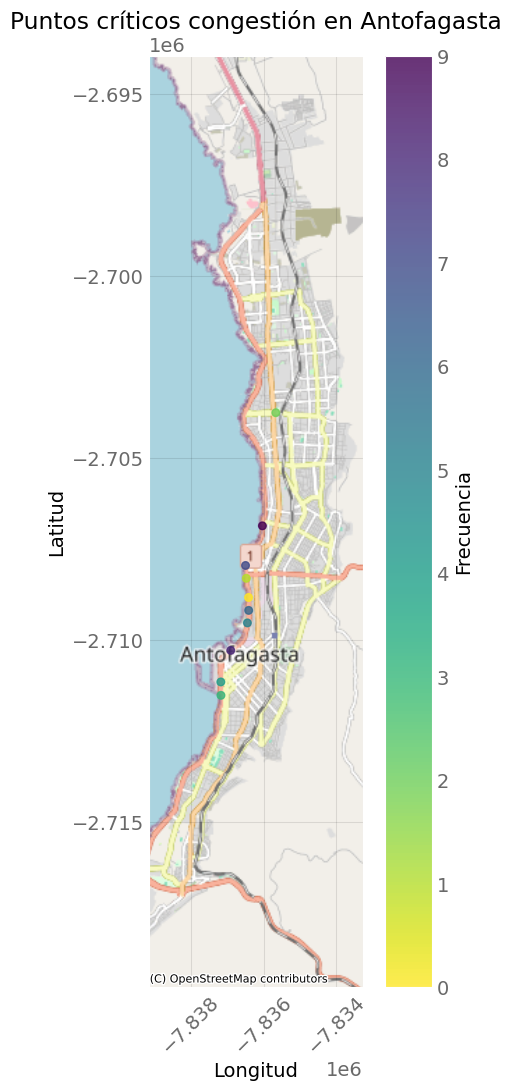

In [12]:
plot_map(jams10, "Puntos críticos congestión en Antofagasta", markersize=MARKERSIZE, cmap="viridis_r")

In [13]:
print("Las 10 coordenadas con más atascos son:")
for _, row in top10.iterrows():
    print(f"{row['y']}, {row['x']}")

Las 10 coordenadas con más atascos son:
-23.633673, -70.395696
-23.629337, -70.396247
-23.591899, -70.388978
-23.655789, -70.402506
-23.652761, -70.402536
-23.639417, -70.395981
-23.636586, -70.395669
-23.626434, -70.396441
-23.645631, -70.400096
-23.617475, -70.392283


In [14]:
utils.freq_nearby(hazards)

,uuid,street,inicio,fin,x,y,geometry,hour,week_day,day_type,freq
0,a123f22e-e5e0-4c6c-8a4e-7434c4fd2110,Av. República de Croacia,2024-08-23 08:53:57-04:00,2024-08-23 14:58:45-04:00,-70.412429,-23.676846,POINT (-7838275.742 -2714079.538),8,4,s,6
6,cb5046a4-282b-4ec0-a46f-228e3f55a2e5,Av. Antonio Rendic,2024-08-23 11:51:06-04:00,2024-08-23 14:58:45-04:00,-70.386217,-23.621585,POINT (-7835357.835 -2707363.924),11,4,s,20
10,7bb29b98-80ea-4916-8018-a65bc2aee354,Tte. Ernesto Riquelme,2024-08-23 12:05:08-04:00,2024-08-23 14:58:45-04:00,-70.391480,-23.647622,POINT (-7835943.71 -2710527.727),12,4,s,35
16,f470e00b-dbd6-4780-a150-3e75f4675c9a,Av. Balmaceda,2024-08-23 12:16:30-04:00,2024-08-23 14:58:45-04:00,-70.400621,-23.646371,POINT (-7836961.281 -2710375.702),12,4,s,76
19,37d01ed3-78a2-4572-b3bd-ffc095bcd72d,Av. Balmaceda,2024-08-23 12:18:05-04:00,2024-08-23 14:58:45-04:00,-70.400347,-23.646161,POINT (-7836930.78 -2710350.182),12,4,s,76
...,...,...,...,...,...,...,...,...,...,...,...
11238,c4fb57cf-1717-4a87-9691-a2b1458023ac,Montegrande,2024-10-12 21:25:22-03:00,2024-10-10 23:34:44-03:00,-70.387614,-23.615464,POINT (-7835513.349 -2706620.242),21,5,f,10
11243,9cdef9e4-a49f-4f8c-87c4-767fccae031b,Av. Argentina,2024-10-12 21:40:24-03:00,2024-10-10 23:34:44-03:00,-70.392469,-23.644913,POINT (-7836053.805 -2710198.522),21,5,f,25
11244,ebc88cc7-b0c8-44c5-85f0-8f39d84bcd64,14 de Febrero,2024-10-12 21:54:04-03:00,2024-10-10 23:34:44-03:00,-70.398358,-23.655126,POINT (-7836709.365 -2711439.669),21,5,f,20
11245,753c4dba-8a4e-472f-a515-170c47061ddc,Av. Grecia,2024-10-12 21:55:00-03:00,NaT,-70.402651,-23.652829,POINT (-7837187.26 -2711160.515),21,5,f,52


In [15]:
hazards = filter_nearby(hazards, threshold=500)
top10 = hazards[["street", "freq", "x", "y", "geometry"]].sort_values("freq", ascending=False).head(10)
hazards10 = top10.copy()
top10

,street,freq,x,y,geometry
32,Av. Grecia,76,-70.402686,-23.655293,POINT (-7837191.156 -2711459.964)
3,Av. Balmaceda,76,-70.400621,-23.646371,POINT (-7836961.281 -2710375.702)
6,Av. Balmaceda,76,-70.397701,-23.643416,POINT (-7836636.228 -2710016.606)
5,Av. Antonio Rendic,72,-70.389409,-23.628164,POINT (-7835713.167 -2708163.291)
14,14 de Febrero,70,-70.393211,-23.650246,POINT (-7836136.404 -2710846.609)
80,Estacionamientos Lider,57,-70.396482,-23.636520,POINT (-7836500.53 -2709178.626)
48,Av. Edmundo Pérez Zujovic,54,-70.396223,-23.629707,POINT (-7836471.698 -2708350.776)
16,Av. Edmundo Pérez Zujovic,53,-70.396215,-23.590976,POINT (-7836470.808 -2703645.373)
30,Av. Edmundo Pérez Zujovic,52,-70.393365,-23.585610,POINT (-7836153.547 -2702993.571)
19,Av. Antonio Rendic,50,-70.388667,-23.625754,POINT (-7835630.568 -2707870.465)


(<Figure size 450x950 with 2 Axes>,
 <Axes: title={'center': 'Puntos críticos peligros en Antofagasta'}, xlabel='Longitud', ylabel='Latitud'>)

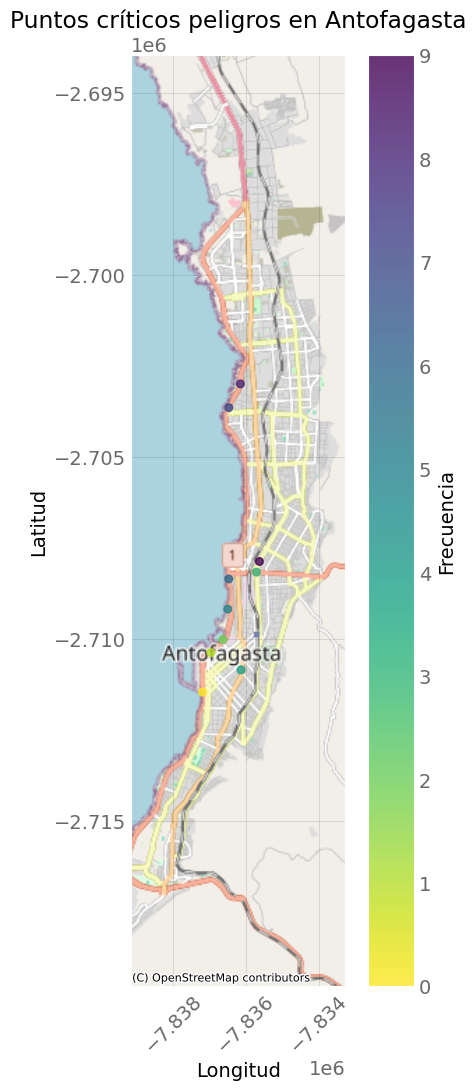

In [16]:
plot_map(hazards10, "Puntos críticos peligros en Antofagasta", markersize=MARKERSIZE, cmap="viridis_r")

In [17]:
print("Las 10 coordenadas con más peligros son:")
for _, row in top10.iterrows():
    print(f"{row['y']}, {row['x']}")

Las 10 coordenadas con más peligros son:
-23.655293, -70.402686
-23.646371, -70.400621
-23.643416, -70.397701
-23.628164, -70.389409
-23.650246, -70.393211
-23.63652, -70.396482
-23.629707, -70.396223
-23.590976, -70.396215
-23.58561, -70.393365
-23.625754, -70.388667
